In [35]:
import torch as th
import numpy as np
from scheduler import GaussianDiffusion 
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

In [114]:
@dataclass
class TrainConfig:
    image_size: int = 28 # cifar10
    num_epochs: int = 10000
    eval_iters: int = 200
    eval_interval: int = 100
    batch_size: int = 32 
    diffusion_steps = 300
    n_sampling_steps = 300
    lr: float = 1e-3

train_cfg = TrainConfig()
device = "cuda" if th.cuda.is_available() else "cpu"

# setup diffusion transformer
dit_cfg = DiTConfig(input_size=train_cfg.image_size,n_heads=4, n_layers=3, in_chans=1, patch_size=14)
model = DiT(dit_cfg)
model.train();  # important! 

### Setup dataset

In [115]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True)
])

train_dataset  = datasets.FashionMNIST(root='./dataset', train=True, download=True, transform=transform)
trainloader = th.utils.data.DataLoader(train_dataset, batch_size=train_cfg.batch_size,shuffle=True)

### DIffusion process

In [116]:
imgs = None
B = 32

x, y = next(iter(trainloader))

x = x.to(device) 
y = y.to(device)

# Generate random timesteps for each image latent
t = th.randint(0, train_cfg.diffusion_steps, (train_cfg.batch_size,), device=device)
print(t)

# add noise
noise = th.randn_like(x) #ground truth noise
a = th.sqrt(gd.alpha_prod)[t].reshape(B,1,1,1)
b = th.sqrt(1- gd.alpha_prod)[t].reshape(B,1,1,1)

x_t = a*x+ b*noise

tensor([260, 152, 256, 239,  68,  60,  91, 165, 201,  55, 136, 223, 222, 204,
        238, 222,  82, 212, 192, 114,  83,  55, 134, 262, 165,  92,  77, 124,
        143, 194,  41,   8])


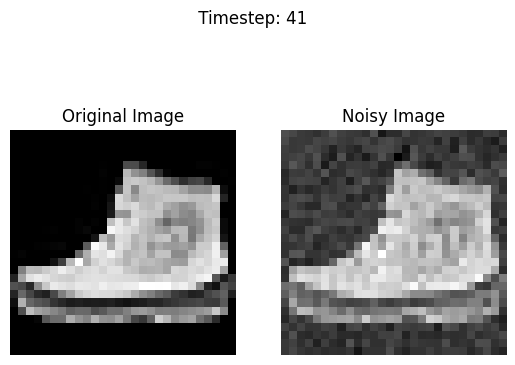

In [117]:
import matplotlib.pyplot as plt

id = np.random.randint(1, B)

# Plot the noisy image
x_t_img = x_t[id].squeeze().clone()
x_img = x[id].squeeze().clone()

fig, axs = plt.subplots(1, 2)
fig.suptitle(f' Timestep: {t[id].item()}')
axs[0].imshow(x_img, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image')
axs[1].imshow(x_t_img, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Noisy Image')
plt.axis('off')
plt.show()